<a href="https://colab.research.google.com/github/lauxpaux/bank_small_dataset/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this analysis is to determine factors influencing if clients sign up for a new term deposit during a bank marketing campaign. The features and target in the dataset are:

● loan: if the client currently holds a loan </br>
● duration: last contact duration in seconds </br>
● poutcome: outcome of the previous marketing campaign </br>
● job: the occupation of the client </br>
● y: whether the client signed up for the new term deposit </br>

Fit, evaluate and interpret a linear model given the above. You are permitted to consult code documentation and may walk through your process with markdown cells or any other means.


This seems like a classic churn problem. How many of the customers actually sign up for a new term deposit during a campaign and how many don't?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/lauxpaux/bank_small_dataset/main/bank_small.csv'
df = pd.read_csv(url)
df

,loan,duration,poutcome,job,y
0,no,1042,unknown,admin.,yes
1,no,1467,unknown,admin.,yes
2,no,1389,unknown,technician,yes
3,no,579,unknown,services,yes
4,no,673,unknown,admin.,yes
...,...,...,...,...,...
15284,no,171,unknown,management,no
15285,no,91,unknown,management,no
15286,no,608,unknown,blue-collar,no
15287,no,100,unknown,entrepreneur,no


### First glance: Data cleaning and data processing
* The data is mostly made up of categorical features so we'll need to do some transformations for the values (one-hot-encoding)
* Check null values and unique values for loan
* Convert duration from seconds to other timestamp values (minutes, date?) so that it makes more sense to us
* poutcome - check unique values, maybe do one hot encoding if value is other than unknown
* job - check different job options and one hot encode values
* y - check for null values, plot the values then drop column


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   loan      15289 non-null  object
 1   duration  15289 non-null  int64 
 2   poutcome  15289 non-null  object
 3   job       15289 non-null  object
 4   y         15289 non-null  object
dtypes: int64(1), object(4)
memory usage: 597.4+ KB


### Checking if we have any missing values:

In [4]:
null_vals = df.loc[df.isnull().any(axis=1)]
null_vals.sum()

loan        0.0
duration    0.0
poutcome    0.0
job         0.0
y           0.0
dtype: float64

In [5]:
print('Non-missing vals: ', df.notnull())

Non-missing vals:         loan  duration  poutcome   job     y
0      True      True      True  True  True
1      True      True      True  True  True
2      True      True      True  True  True
3      True      True      True  True  True
4      True      True      True  True  True
...     ...       ...       ...   ...   ...
15284  True      True      True  True  True
15285  True      True      True  True  True
15286  True      True      True  True  True
15287  True      True      True  True  True
15288  True      True      True  True  True

[15289 rows x 5 columns]


Let's look at the unique values represented in each column. This will help us determine the options that we are working with and it helps us better gauge what our final one-hot-encoded dataset will look like.

### Looking at the unique values in each column:

In [6]:
def get_unique_vals(df):
  cols = ['loan', 'duration', 'poutcome', 'job', 'y']
  for col in cols:
    unique_vals = df[col].unique()
    print(f'{col}:, {unique_vals}')

get_unique_vals(df)

loan:, ['no' 'yes']
duration:, [1042 1467 1389 ...  948 3322 2027]
poutcome:, ['unknown' 'other' 'failure' 'success']
job:, ['admin.' 'technician' 'services' 'management' 'retired' 'unemployed'
 'blue-collar' 'entrepreneur' 'housemaid' 'self-employed' 'unknown'
 'student']
y:, ['yes' 'no']


### Visualizing distribution of each feature:

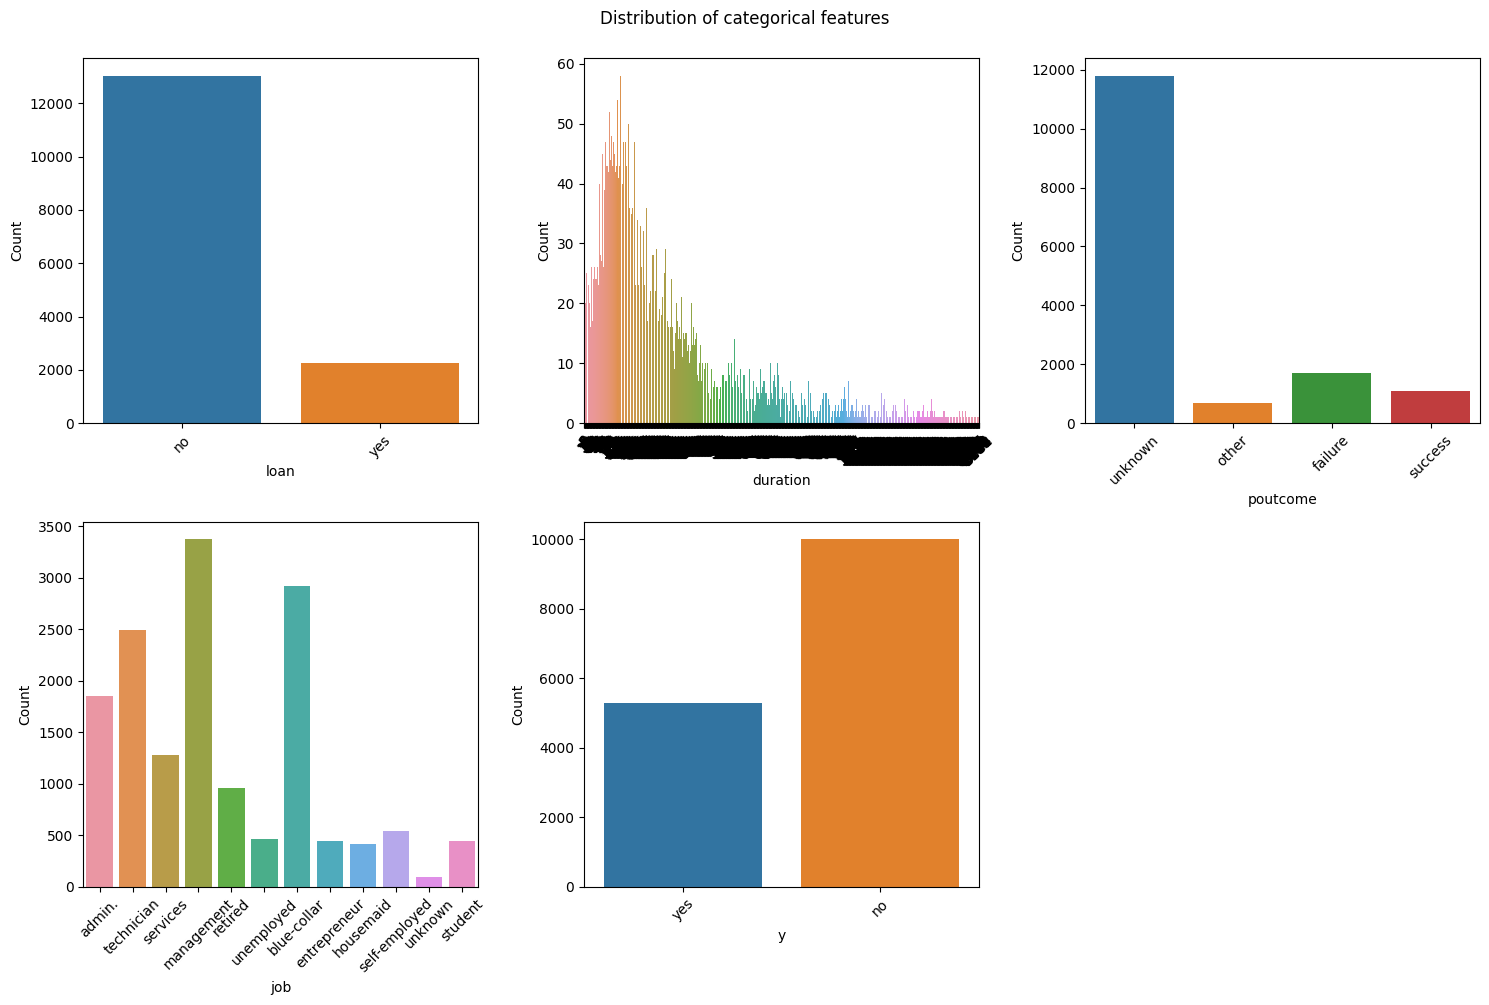

In [7]:
import matplotlib.pyplot as plt

def plot_distributions(df):
    cols = df.columns
    num_cols = len(cols)
    rows = (num_cols - 1) // 3 + 1

    plt.figure(figsize=(15, 5 * rows))
    plt.suptitle('Distribution of categorical features', y=1)

    for i in range(num_cols):
        plt.subplot(rows, 3, i + 1)
        sns.countplot(x=df[cols[i]])
        plt.xlabel(cols[i])
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_distributions(df)


### Dropping y feature:

In [8]:
y = df['y']
y

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
15284     no
15285     no
15286     no
15287     no
15288     no
Name: y, Length: 15289, dtype: object

In [9]:
df = df.drop(columns='y', axis=1)
df

,loan,duration,poutcome,job
0,no,1042,unknown,admin.
1,no,1467,unknown,admin.
2,no,1389,unknown,technician
3,no,579,unknown,services
4,no,673,unknown,admin.
...,...,...,...,...
15284,no,171,unknown,management
15285,no,91,unknown,management
15286,no,608,unknown,blue-collar
15287,no,100,unknown,entrepreneur


### Transforming 'Loan' feature:

In [10]:
df['loan']= df['loan'].replace({'yes': 1, 'no': 0})
df

,loan,duration,poutcome,job
0,0,1042,unknown,admin.
1,0,1467,unknown,admin.
2,0,1389,unknown,technician
3,0,579,unknown,services
4,0,673,unknown,admin.
...,...,...,...,...
15284,0,171,unknown,management
15285,0,91,unknown,management
15286,0,608,unknown,blue-collar
15287,0,100,unknown,entrepreneur


### Feature engineering: Transforming 'duration' feature from seconds to hours

In [11]:
df['duration'].describe()

count    15289.000000
mean       330.878671
std        322.269855
min          0.000000
25%        124.000000
50%        222.000000
75%        417.000000
max       3881.000000
Name: duration, dtype: float64

In [12]:
def seconds_to_hours(feature):
  df['hours_since'] = df['duration'] / 60
  df.drop(columns=['duration'], inplace=True)
  return df

transformed_df2 = seconds_to_hours(df['duration']).round(0)
# transformed_df2

### Transforming 'poutcome' feature: One Hot Encoding






In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

In [14]:
outcome_ft = df[['poutcome']]

def transform_poutcome(outcome_ft):
  encoded_poutcome = encoder.fit_transform(outcome_ft)
  poutcome_arr = encoded_poutcome.toarray()
  poutcome_df = pd.DataFrame(poutcome_arr, columns=encoder.get_feature_names_out(['poutcome']))
  # print(poutcome_df)
  transformed_df3 = pd.concat([transformed_df2, poutcome_df], axis=1).drop(columns=['poutcome'])
  return transformed_df3

transformed_df3 = transform_poutcome(outcome_ft)
# transformed_df3

### Transforming 'job' feature: One Hot Encoding


In [15]:
job_ft = df[['job']]

def transform_job_feature(feature):
  encoded_job_ft = encoder.fit_transform(job_ft)
  job_arr = encoded_job_ft.toarray()
  job_df = pd.DataFrame(job_arr, columns=encoder.get_feature_names_out(['job']))
  transformed_df4 = pd.concat([transformed_df3, job_df], axis=1).drop(columns=['job'])
  return transformed_df4

transformed_df4 = transform_job_feature(job_ft)
transformed_df4

,loan,hours_since,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,17.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,24.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,23.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15285,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15286,0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15287,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## To do: make it all the same data type

In [16]:
transformed_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan               15289 non-null  int64  
 1   hours_since        15289 non-null  float64
 2   poutcome_failure   15289 non-null  float64
 3   poutcome_other     15289 non-null  float64
 4   poutcome_success   15289 non-null  float64
 5   poutcome_unknown   15289 non-null  float64
 6   job_admin.         15289 non-null  float64
 7   job_blue-collar    15289 non-null  float64
 8   job_entrepreneur   15289 non-null  float64
 9   job_housemaid      15289 non-null  float64
 10  job_management     15289 non-null  float64
 11  job_retired        15289 non-null  float64
 12  job_self-employed  15289 non-null  float64
 13  job_services       15289 non-null  float64
 14  job_student        15289 non-null  float64
 15  job_technician     15289 non-null  float64
 16  job_unemployed     152

In [17]:
transformed_df4 = transformed_df4.astype(float)
transformed_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan               15289 non-null  float64
 1   hours_since        15289 non-null  float64
 2   poutcome_failure   15289 non-null  float64
 3   poutcome_other     15289 non-null  float64
 4   poutcome_success   15289 non-null  float64
 5   poutcome_unknown   15289 non-null  float64
 6   job_admin.         15289 non-null  float64
 7   job_blue-collar    15289 non-null  float64
 8   job_entrepreneur   15289 non-null  float64
 9   job_housemaid      15289 non-null  float64
 10  job_management     15289 non-null  float64
 11  job_retired        15289 non-null  float64
 12  job_self-employed  15289 non-null  float64
 13  job_services       15289 non-null  float64
 14  job_student        15289 non-null  float64
 15  job_technician     15289 non-null  float64
 16  job_unemployed     152

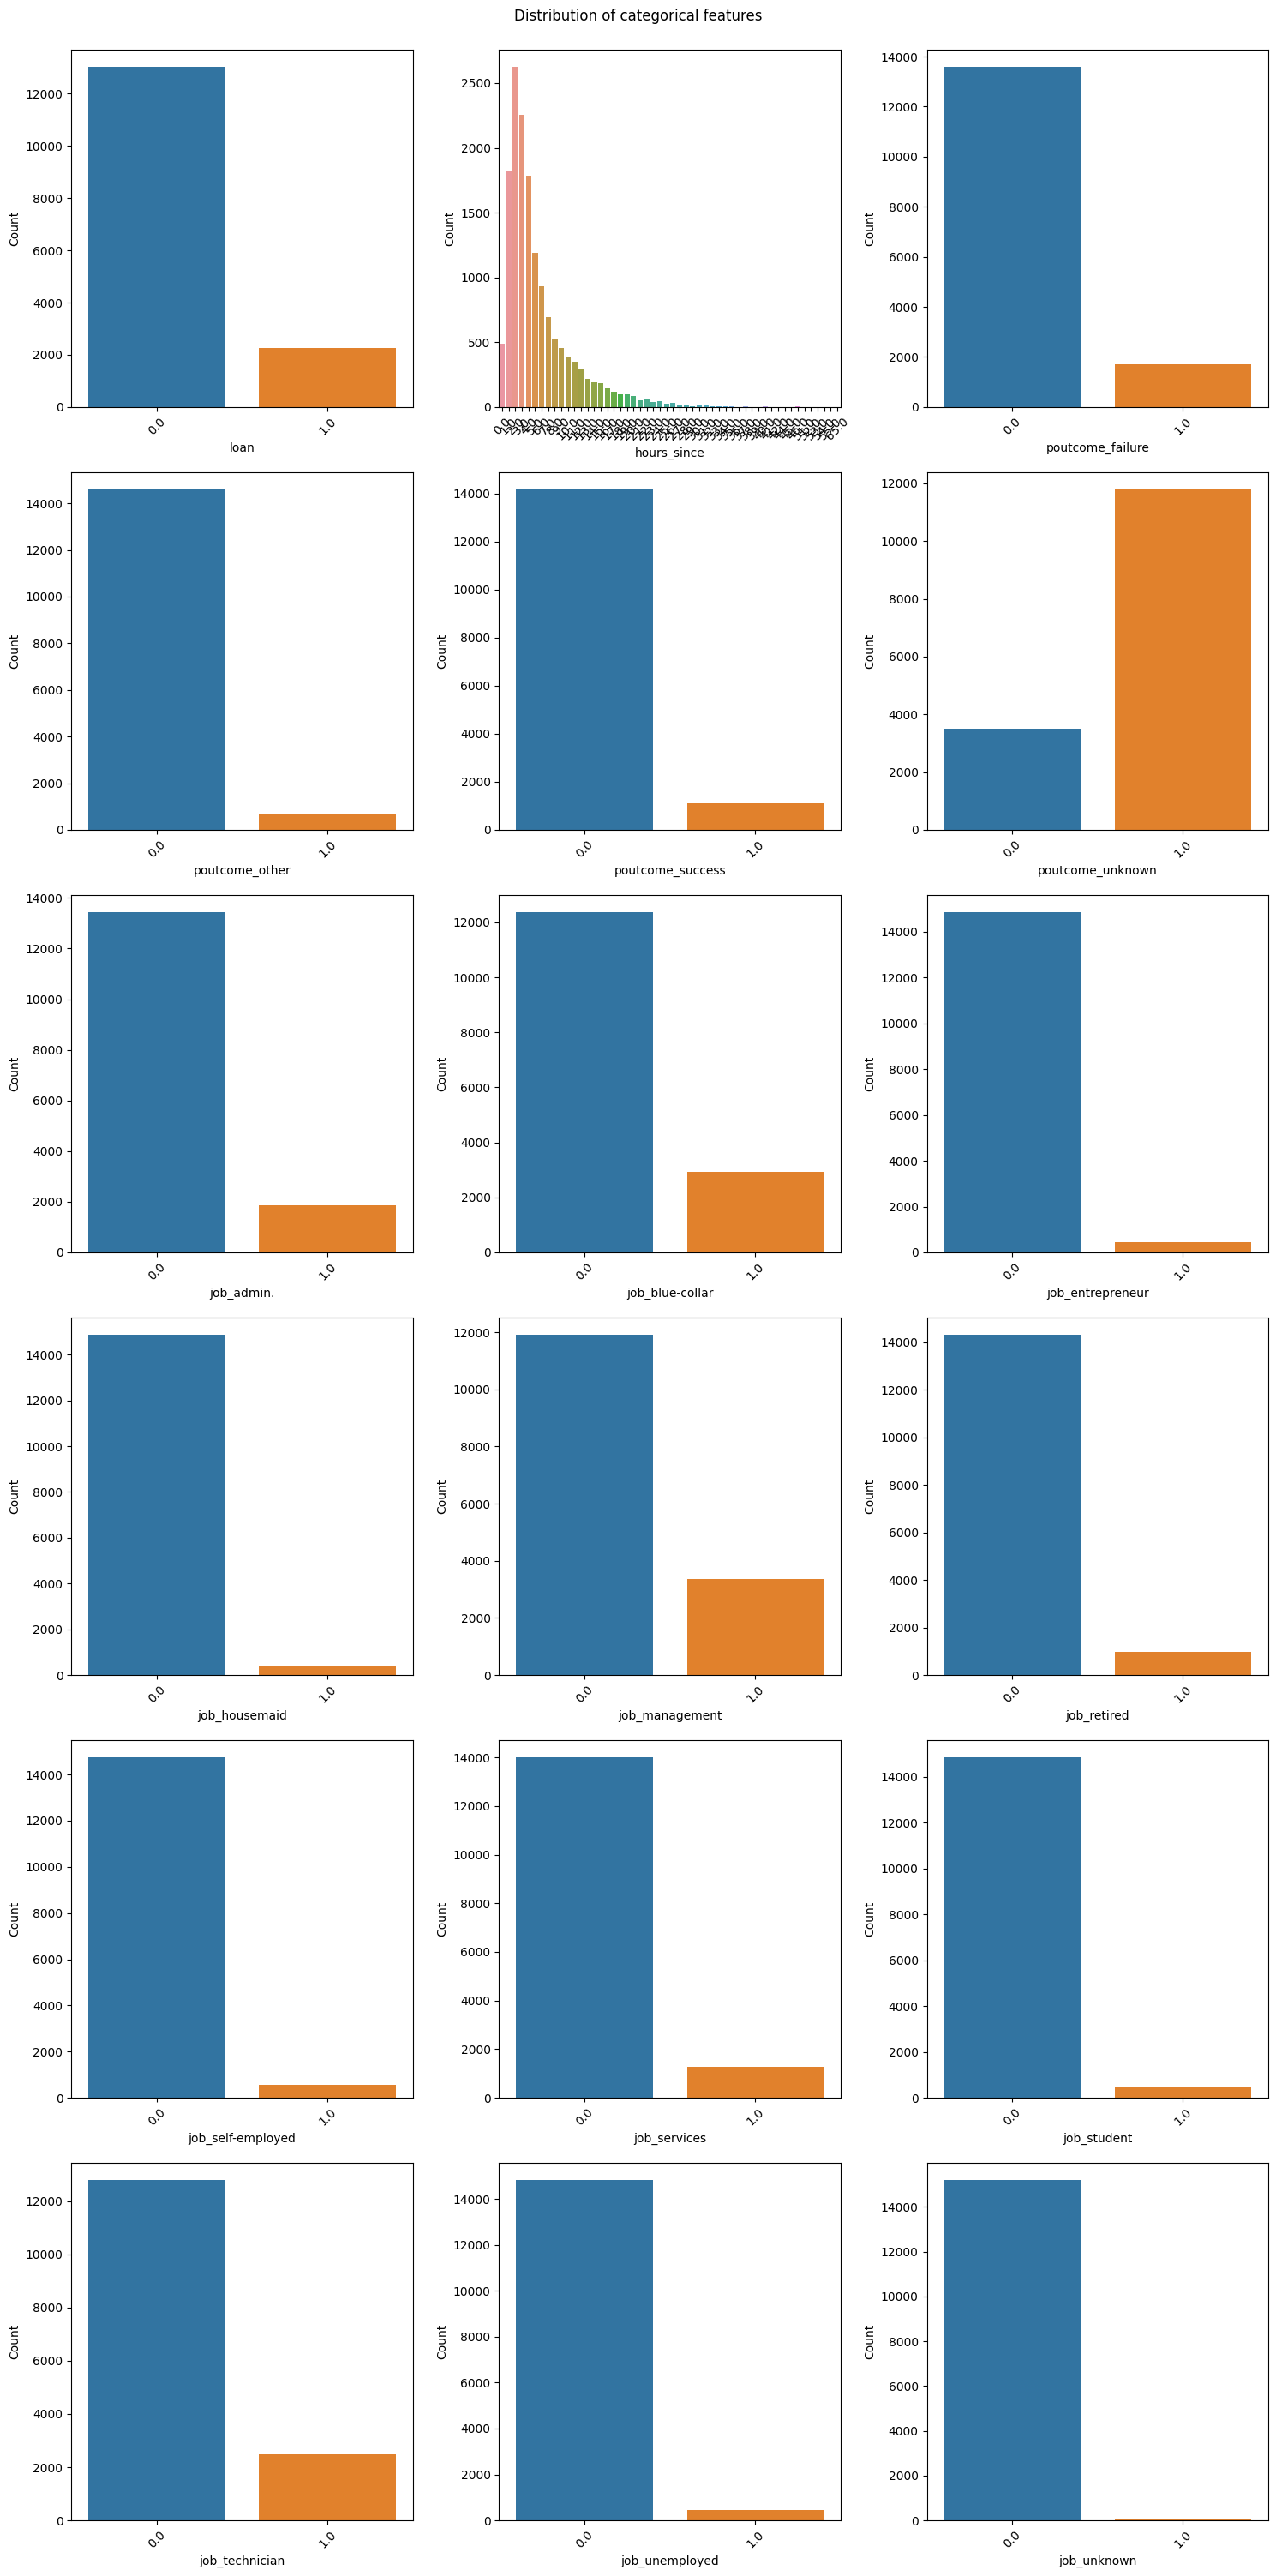

In [18]:
plot_distributions(transformed_df4)

In [19]:
print(transformed_df4.columns)

Index(['loan', 'hours_since', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown'],
      dtype='object')


### Exploring relationships between binary features using using Phi coefficients:

In [20]:
!pip install phik

In [21]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [22]:
phik_corr = transformed_df4.phik_matrix()
phik_corr.round(2)

interval columns not set, guessing: ['loan', 'hours_since', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown']


,loan,hours_since,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
loan,1.00,0.02,0.00,0.00,0.12,0.09,0.04,0.07,0.05,0.03,0.06,0.05,0.01,0.07,0.11,0.00,0.05,0.04
hours_since,0.02,1.00,0.03,0.00,0.04,0.06,0.03,0.04,0.01,0.03,0.01,0.04,0.06,0.00,0.00,0.00,0.03,0.00
poutcome_failure,0.00,0.03,1.00,0.12,0.15,0.85,0.02,0.01,0.00,0.02,0.02,0.00,0.00,0.01,0.01,0.00,0.00,0.00
poutcome_other,0.00,0.00,0.12,1.00,0.09,0.59,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.00,0.05,0.00,0.01,0.01
poutcome_success,0.12,0.04,0.15,0.09,1.00,0.72,0.01,0.11,0.05,0.02,0.04,0.11,0.00,0.04,0.09,0.02,0.04,0.01
poutcome_unknown,0.09,0.06,0.85,0.59,0.72,1.00,0.02,0.09,0.04,0.04,0.06,0.07,0.00,0.03,0.09,0.02,0.00,0.00
job_admin.,0.04,0.03,0.02,0.00,0.01,0.02,1.00,0.28,0.10,0.10,0.30,0.15,0.11,0.17,0.10,0.25,0.10,0.04
job_blue-collar,0.07,0.04,0.01,0.01,0.11,0.09,0.28,1.00,0.13,0.13,0.39,0.20,0.14,0.23,0.13,0.33,0.13,0.06
job_entrepreneur,0.05,0.01,0.00,0.00,0.05,0.04,0.10,0.13,1.00,0.04,0.14,0.07,0.05,0.08,0.04,0.12,0.04,0.01
job_housemaid,0.03,0.03,0.02,0.02,0.02,0.04,0.10,0.13,0.04,1.00,0.14,0.07,0.05,0.08,0.04,0.11,0.04,0.01


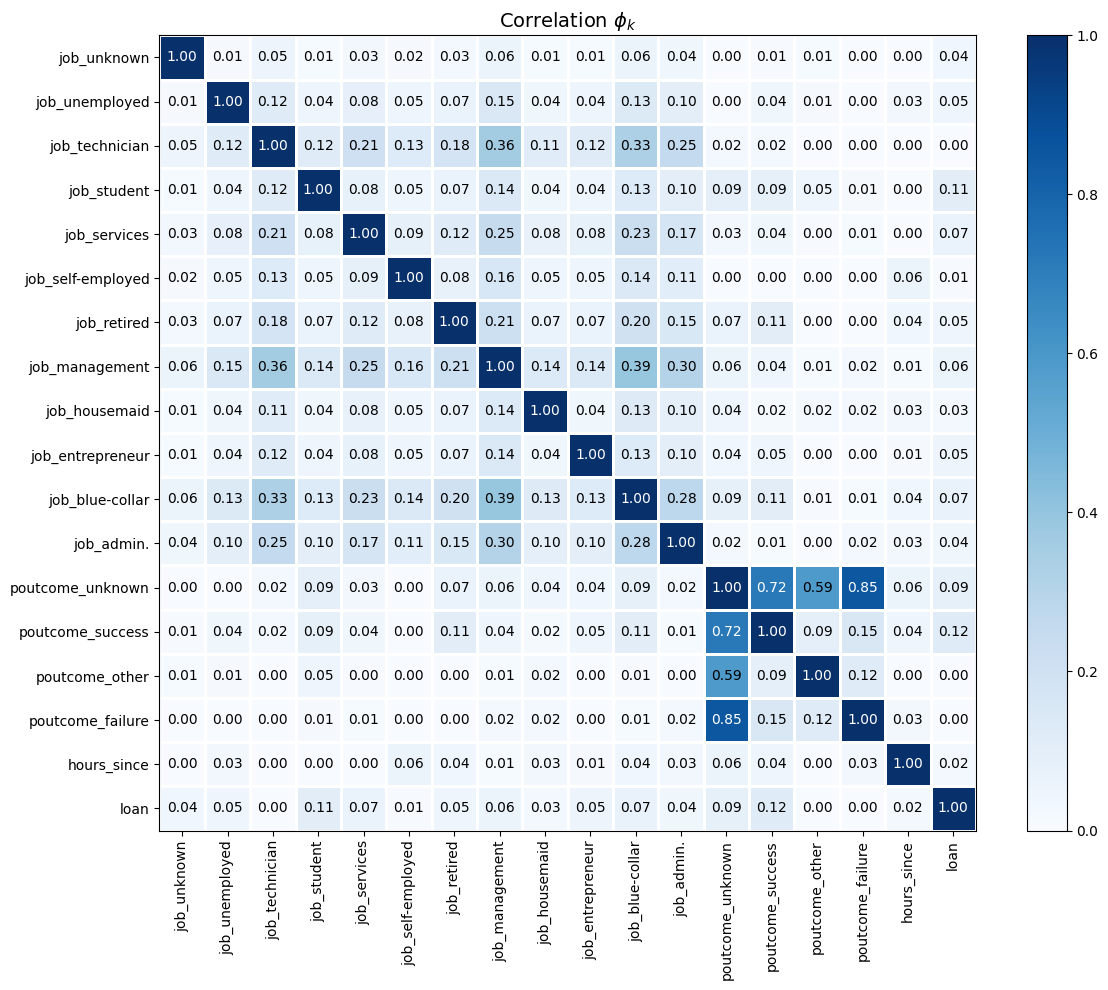

In [23]:
plot_correlation_matrix(phik_corr.values,
                        x_labels=phik_corr.columns,
                        y_labels=phik_corr.index,
                        vmin=0, vmax=1, color_map='Blues',
                        title=r'Correlation $\phi_k$',
                        figsize=(12,10))

plt.tight_layout()

### Investigating the distribution of y-feature / Data Balance

In [24]:
y = y.replace({'yes': 1, 'no': 0})
y


0        1
1        1
2        1
3        1
4        1
        ..
15284    0
15285    0
15286    0
15287    0
15288    0
Name: y, Length: 15289, dtype: int64

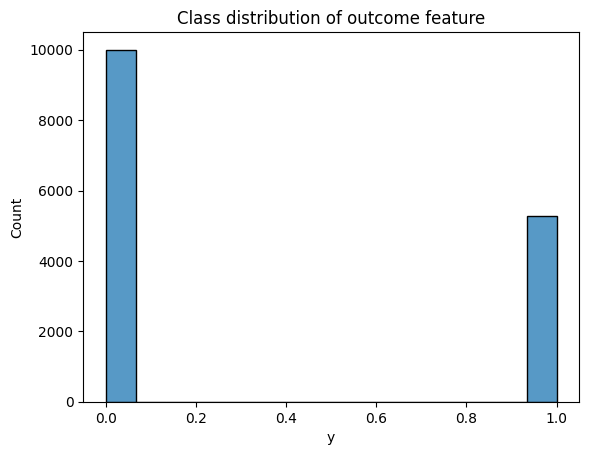

In [25]:
yPlot = sns.histplot(y)
yPlot.set_title('Class distribution of outcome feature');

As we can see from the figure above, we have an **slighty imbalanced** dataset for our outcome feature. We can determine the ratio of the class distribution based on the training dataset.

Because we want to know the factors that influence if a client signs up for a new deposit during a bank marketing campaign, we care more about the minority (1)class, those in the "yes" outcome. We have less representation of that class, which is a common with classification problems.

### Inspecting data imbalance ratio:

In [26]:
def get_proportions(y):
  unique_labels, counts = np.unique(y, return_counts=True)
  proportions = counts / len(y)

  return proportions

proportions = get_proportions(y)
print(proportions)

[0.65406501 0.34593499]


In [27]:
def get_gcd(class0, class1):
  # find common denominator between two values
  while class1:
    class0, class1 = class1, class0 % class1
  return class0

gcd_val = get_gcd(proportions[0], proportions[1])
print(gcd_val)

2.220446049250313e-16


In [28]:
def get_ratio(proportions):
  common_factor = 10
  gcd_val = get_gcd(int(proportions[0] * common_factor), int(proportions[1] * common_factor))

  simplified_class0 = int(proportions[0] * common_factor) // gcd_val
  simplified_class1 = int(proportions[1] * common_factor) // gcd_val

  formatted_ratio = "{}:{}".format(simplified_class0, simplified_class1)
  print("Dataset ratio", formatted_ratio)

get_ratio(proportions)

Dataset ratio 2:1


## Todo:
* make it all same data type
* create x and y features

* scaling vs not scaling
* Some other options: We could create a feature which provides information on which job titles are most likely to have loans.

In [29]:
transformed_df4

,loan,hours_since,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0.0,17.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,24.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,23.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15285,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15286,0.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15287,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Looks like we have a magnitude problem: We need to scale our hours_since feature.

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

minMax_scaler = MinMaxScaler()
minMax_scaler.fit(transformed_df4[['hours_since']])

MinMaxScaler()

In [31]:
transformed_df4['hours_since'] = minMax_scaler.transform(transformed_df4[['hours_since']]).round(2)
transformed_df4

,loan,hours_since,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0.0,0.26,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.37,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.35,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.17,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,0.0,0.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15285,0.0,0.03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15286,0.0,0.15,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15287,0.0,0.03,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
transformed_df4['hours_since'].describe()

count    15289.000000
mean         0.085695
std          0.082247
min          0.000000
25%          0.030000
50%          0.060000
75%          0.110000
max          1.000000
Name: hours_since, dtype: float64

In [35]:
from sklearn.model_selection import train_test_split

X = transformed_df4
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [36]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
model = LogisticRegression(solver='liblinear')
scoring='neg_log_loss'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))

Logloss: -0.446 (0.016)


In [54]:
reg_model = model.fit(X_train, y_train)


In [58]:
y_pred_probs = reg_model.predict_proba(X_test)[:, 1]


In [59]:
from sklearn.metrics import precision_recall_curve, auc


precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)


In [63]:
auc_pr = auc(recall, precision)
auc_pr

0.7495892333040859

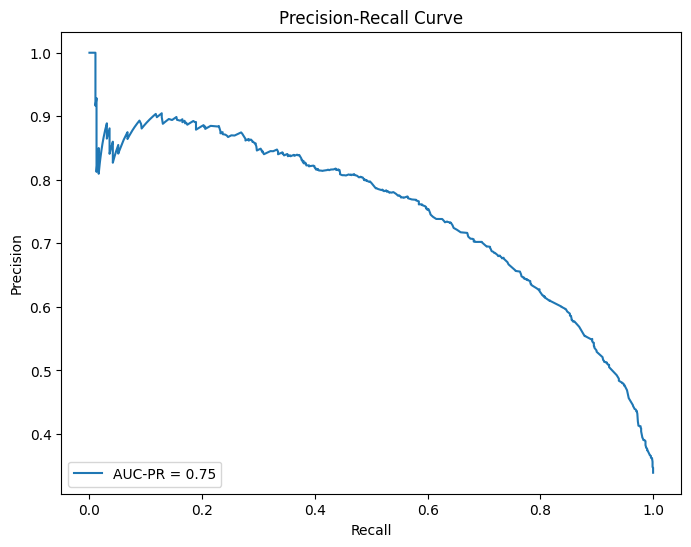

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
# plt.grid(True)
plt.show()

In [56]:
print(classification_report(y_test,y_pred_probs))
print('Confusion Matrix: \n', confusion_matrix(y_test,y_pred_probs))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2021
           1       0.78      0.53      0.63      1037

    accuracy                           0.79      3058
   macro avg       0.79      0.73      0.74      3058
weighted avg       0.79      0.79      0.78      3058

Confusion Matrix: 
 [[1865  156]
 [ 483  554]]


### Plotting precision recall curve to measure model's performance. We are opting for precision-recall curve because we have imbalanced data.

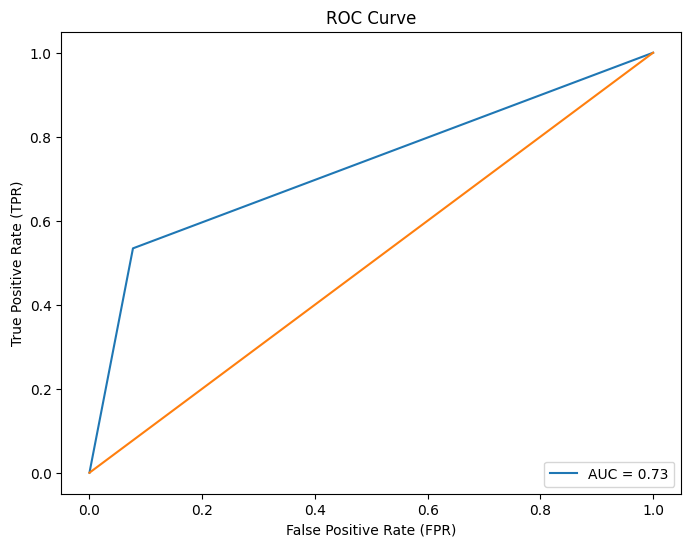

model 1 AUC score: 0.7285219276669227


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1])  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
# plt.grid(True)
plt.show()
print(f'model 1 AUC score: {auc_roc}')


Further Readings:

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7